In [1]:
import sys
import os

# Add project root to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

os.chdir(project_root)

In [2]:
# === Imports ===
from tools.analysis_tools.hierarchical_prediction_distribution import (
    calculate_confusion_matrix, 
    calculate_hierarchical_prediction_distribution, 
    plot_stacked_percentage_bar_chart,
)
from mmengine import Config
from mmengine.fileio import load
from mmengine.registry import init_default_scope
from mmdet.registry import DATASETS
from mmdet.utils import update_data_root
from hod.utils.tree import HierarchyTree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# === Configuration ===
# Define the models to analyze. Add a new entry for each model you want to compare.
MODELS_TO_ANALYZE = {
    "DINO": {
        "config_path": "configs/hod/models/dino/dino-r50_improved_8xb2-36e_aircraft-func.py",
        "prediction_path": "outputs/inference/dino-r50_improved_8xb2-36e_aircraft-func.pkl" # <-- SET MANUALLY
    },
    "DINO-E": {
        "config_path": "configs/hod/models/embedding_dino/embed_dino-r50-sep-eucl_improved_8xb2-36e_aircraft-func.py",
        "prediction_path": "outputs/inference/embed_dino-r50-sep-eucl_improved_8xb2-36e_aircraft-func.pkl" # <-- SET MANUALLY
    },
    "DINO-H (M)": {
        "config_path": "configs/hod/models/hierarchical_dino_func_sweep/hi_dino-r50-hfl10-sep-eucl_improved_8xb2-36e_aircraft-func.py",
        "prediction_path": "outputs/inference/hi_dino-r50-hfl10-sep-eucl_improved_8xb2-36e_aircraft-func-multi.pkl"
    },
    "DINO-H (S)": {
        "config_path": "configs/hod/models/hierarchical_dino_func_sweep/hi_dino-r50-hfl10-sep-eucl_improved_8xb2-36e_aircraft-func.py",
        "prediction_path": "outputs/inference/hi_dino-r50-hfl10-sep-eucl_improved_8xb2-36e_aircraft-func-single.pkl"
    },
}

# --- Analysis Parameters ---
# Score threshold for filtering detections
score_thr = 0.3

# IoU threshold for matching predictions to ground truth
tp_iou_thr = 0.5

In [10]:
# === Process Models ===
# This cell iterates through each model defined in the configuration, calculates the 
# hierarchical statistics, and stores them for plotting.

all_model_stats = {}

for model_name, model_info in MODELS_TO_ANALYZE.items():
    print(f"Processing model: {model_name}...")
    
    config_path = model_info['config_path']
    prediction_path = model_info['prediction_path']

    # --- Load Config and Dataset ---
    cfg = Config.fromfile(config_path)
    update_data_root(cfg)
    init_default_scope(cfg.get('default_scope', 'mmdet'))
    dataset = DATASETS.build(cfg.test_dataloader.dataset)

    # --- Load Prediction Results ---
    results = load(prediction_path)

    # --- Calculate Confusion Matrix ---
    confusion_matrix = calculate_confusion_matrix(
        dataset,
        results,
        score_thr=score_thr,
        tp_iou_thr=tp_iou_thr
    )

    # --- Generate Hierarchical Distribution ---
    stats = calculate_hierarchical_prediction_distribution(
        dataset,
        confusion_matrix,
        verbose=False
    )
    
    # Store only the total stats for comparison
    all_model_stats[model_name] = stats['Total']

print("\nAll models processed.")

Processing model: DINO...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15516.62img/s]


Processing model: DINO-E...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 15279.90img/s]


Processing model: DINO-H (M)...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 10672.68img/s]


Processing model: DINO-H (S)...
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Analyzing detections: 100%|██████████| 1295/1295 [00:00<00:00, 14941.13img/s]


All models processed.


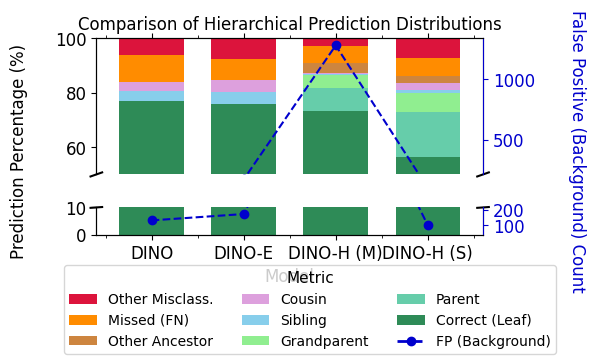

In [16]:
# === Plot Comparative Hierarchical Distribution ===
# This step converts the collected statistics into a pandas DataFrame and plots a
# stacked bar chart to compare the hierarchical prediction distribution across all models,
# with the False Positive (Background) counts overlaid as a line plot.

if all_model_stats:
    # Convert the stats dictionary to a pandas DataFrame
    df = pd.DataFrame.from_dict(all_model_stats, orient='index')

    # --- Define Plotting Order, Labels, and Colors ---
    # Use the same definitions as the robustness notebook for consistency
    plot_order = [
        'tp_percentage', 
        'parent_percentage', 
        'grandparent_percentage', 
        'sibling_percentage', 
        'cousin_percentage', 
        'ancestor_percentage', 
        'fn_percentage', 
        'other_class_percentage'
    ]
    
    plot_labels = {
        'tp_percentage': 'Correct (Leaf)',
        'parent_percentage': 'Parent',
        'grandparent_percentage': 'Grandparent',
        'sibling_percentage': 'Sibling',
        'cousin_percentage': 'Cousin',
        'ancestor_percentage': 'Other Ancestor',
        'fn_percentage': 'Missed (FN)',
        'other_class_percentage': 'Other Misclass.',
        'fp_bg': 'FP (Background)'
    }

    plot_colors = {
        'tp_percentage': '#2E8B57',
        'parent_percentage': '#66CDAA',
        'grandparent_percentage': '#90EE90',
        'sibling_percentage': '#87CEEB',
        'cousin_percentage': '#DDA0DD',
        'ancestor_percentage': '#CD853F',
        'fn_percentage': '#FF8C00',
        'other_class_percentage': '#DC143C',
        'fp_bg': '#0000CD' # Add color for fp_bg
    }

    # Filter out any metrics that are not present in the DataFrame and rename for plot
    available_metrics = [metric for metric in plot_order if metric in df.columns]
    df_plot = df[available_metrics].rename(columns=plot_labels)
    plot_order_labels = [plot_labels[metric] for metric in available_metrics]
    color_order = [plot_colors[metric] for metric in available_metrics]

    # --- Dynamic Y-Axis Break Parameters ---
    bottom_axis_max = 10
    top_axis_min = 50
    top_axis_max = 100

    # --- Create Stacked Bar Chart for Percentages with a broken y-axis ---
    # The height ratio is set to match the data range to keep the scale consistent
    height_ratios = [top_axis_max - top_axis_min, bottom_axis_max]
    fig, (ax_top, ax_bottom) = plt.subplots(2, 1, sharex=True, figsize=(6, 3), gridspec_kw={'height_ratios': height_ratios})
    fig.subplots_adjust(hspace=0.1)  # adjust space between axes

    # Plot on both axes
    for ax in [ax_top, ax_bottom]:
        df_plot[plot_order_labels].plot(
            kind='bar', 
            stacked=True, 
            color=color_order,
            width=0.7,
            ax=ax,
            legend=False
        )

    # Set y-axis limits for the two parts of the plot
    ax_top.set_ylim(bottom=top_axis_min, top=top_axis_max)  # The top part of the axis
    ax_bottom.set_ylim(top=bottom_axis_max)   # The bottom part of the axis

    # Hide the spines and ticks to create the "break"
    ax_top.spines['bottom'].set_visible(False)
    ax_bottom.spines['top'].set_visible(False)
    ax_top.xaxis.tick_top()
    ax_top.tick_params(labeltop=False)  # Don't put tick labels at the top
    ax_bottom.xaxis.tick_bottom()

    # Add diagonal lines to indicate the break
    d = .015  # how big to make the diagonal lines in axes coordinates
    kwargs = dict(transform=ax_top.transAxes, color='k', clip_on=False)
    ax_top.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax_top.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax_bottom.transAxes)  # switch to the bottom axes
    ax_bottom.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax_bottom.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    # Set labels and title
    fig.text(0.0, 0.5, 'Prediction Percentage (%)', va='center', rotation='vertical', fontsize=12)
    ax_bottom.set_xlabel('Model', fontsize=12)
    ax_top.set_title('Comparison of Hierarchical Prediction Distributions', fontsize=12)
    ax_bottom.tick_params(axis='x', rotation=0, labelsize=12)
    ax_top.tick_params(axis='y', labelsize=12)
    ax_bottom.tick_params(axis='y', labelsize=12)

    # --- Create Line Plot for FP (Background) Counts on a secondary y-axis ---
    if 'fp_bg' in df.columns:
        ax2_top = ax_top.twinx()
        ax2_bottom = ax_bottom.twinx()
        
        fp_bg_color = plot_colors['fp_bg']
        
        for ax2 in [ax2_top, ax2_bottom]:
            df['fp_bg'].plot(
                kind='line', 
                marker='o', 
                color=fp_bg_color, 
                ax=ax2,
                linestyle='--',
                legend=False
            )
        
        # Synchronize the y-axis limits of the secondary axes to match the primary axis scale
        fp_bg_max = df['fp_bg'].max()
        if fp_bg_max > 0:
            # Calculate the split point for the secondary axis to maintain scale
            y_split_secondary = bottom_axis_max * fp_bg_max / (top_axis_max - top_axis_min + bottom_axis_max)
            ax2_top.set_ylim(bottom=y_split_secondary)
            ax2_bottom.set_ylim(top=y_split_secondary)

        ax2_top.spines['bottom'].set_visible(False)
        ax2_bottom.spines['top'].set_visible(False)
        
        fig.text(0.93, 0.5, 'False Positive (Background) Count', va='center', rotation=-90, fontsize=12, color=fp_bg_color)
        ax2_top.tick_params(axis='y', labelsize=12, colors=fp_bg_color)
        ax2_bottom.tick_params(axis='y', labelsize=12, colors=fp_bg_color)
        ax2_top.spines['right'].set_color(fp_bg_color)
        ax2_bottom.spines['right'].set_color(fp_bg_color)
        ax2_top.grid(False)
        ax2_bottom.grid(False)

    # --- Combine Legends and place at the bottom ---
    h1, l1 = ax_bottom.get_legend_handles_labels()

    if 'fp_bg' in df.columns:
        from matplotlib.lines import Line2D
        h2 = [Line2D([0], [0], color=plot_colors['fp_bg'], lw=2, ls='--', marker='o')]
        l2 = [plot_labels['fp_bg']]
        # Reverse the order of handles and labels to match the stack order
        handles = list(reversed(h1)) + h2
        labels = list(reversed(l1)) + l2
        fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=3, title='Metric', fontsize=10, title_fontsize=11)
    else:
        handles = reversed(h1)
        labels = reversed(l1)
        fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=3, title='Prediction Type', fontsize=10, title_fontsize=11)

    plt.tight_layout(rect=[0.05, 0, 0.9, 1]) # Adjust layout automatically
    plt.show()

else:
    print("No model statistics were generated. Please check the configuration and processing steps.")

In [18]:
# === Display Statistics Table ===
# Print the DataFrame as a formatted table for easy copying.
if all_model_stats:
    display(df)
else:
    print("No model statistics were generated.")

,total_gt,tp,parent_tp,grandparent_tp,sibling_tp,cousin_tp,ancestor_tp,distance,fn,fp_bg,tp_percentage,parent_percentage,grandparent_percentage,sibling_percentage,cousin_percentage,ancestor_percentage,fn_percentage,other_class_percentage,avg_distance,other_class
DINO,2297.0,1766.0,0.0,0.0,87.0,71.0,0.0,0.0,230.0,132.0,76.882891,0.000000,0.000000,3.787549,3.090988,0.000000,10.013061,6.225512,0.000000,143.0
DINO-E,2297.0,1745.0,0.0,0.0,102.0,94.0,0.0,0.0,184.0,172.0,75.968655,0.000000,0.000000,4.440575,4.092294,0.000000,8.010448,7.488028,0.000000,172.0
DINO-H-Multi,2297.0,1681.0,196.0,113.0,2.0,8.0,89.0,708.0,140.0,1282.0,73.182412,8.532869,4.919460,0.087070,0.348280,3.874619,6.094906,2.960383,1.778894,68.0
DINO-H-Single,2297.0,1299.0,372.0,164.0,28.0,57.0,60.0,908.0,154.0,101.0,56.552024,16.195037,7.139747,1.218981,2.481498,2.612103,6.704397,7.096212,1.523490,163.0
